# CLIP Image-Text Matching Demo

This notebook demonstrates using CLIP (Contrastive Language-Image Pre-Training) for:
1. Computing image-text similarity
2. Image search by text query
3. Finding best text description for an image

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

from src.image_text_matcher import ImageTextMatcher

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 1. Initialize the Matcher

Load the CLIP model from HuggingFace.

In [2]:
# Initialize the image-text matcher
matcher = ImageTextMatcher(
    model_name="openai/clip-vit-base-patch32",
    device=device
)
print(matcher)
print(f'Embedding dimension: {matcher.embedding_dim}')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ImageTextMatcher(model=openai/clip-vit-base-patch32, device=cuda, num_images=0, num_texts=0)
Embedding dimension: 512


## 2. Load Sample Images

We'll use some sample images from the web for demonstration.

In [3]:
def load_image_from_url(url):
    """Load an image from URL."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Sample image URLs (public domain / freely usable)
image_urls = [
    'https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400',  # Dog
    'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400',  # Cat
    'https://images.unsplash.com/photo-1494976388531-d1058494cdd8?w=400',  # Car
    'https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=400',  # Person
]

# Load images
images = []
for url in image_urls:
    try:
        img = load_image_from_url(url)
        images.append(img)
        print(f'Loaded image: {img.size}')
    except Exception as e:
        print(f'Failed to load: {e}')

print(f'\nTotal images loaded: {len(images)}')

Loaded image: (400, 267)
Loaded image: (400, 275)
Loaded image: (400, 267)
Loaded image: (400, 600)

Total images loaded: 4


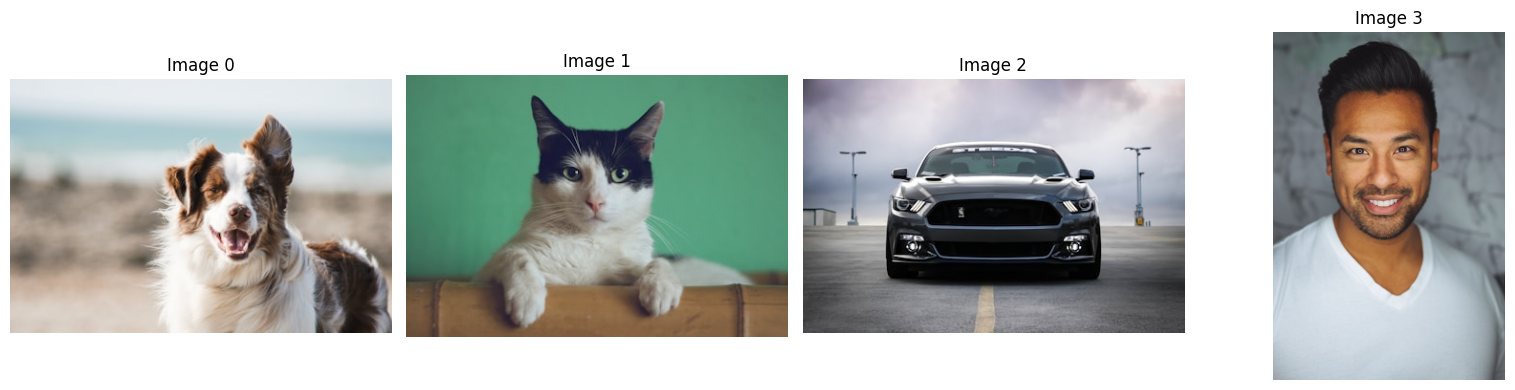

In [4]:
# Display loaded images
fig, axes = plt.subplots(1, len(images), figsize=(4*len(images), 4))
for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].set_title(f'Image {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 3. Basic Usage: Compute Similarity

Add texts and images, then compute the similarity matrix.

In [5]:
# Define text descriptions
texts = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a car",
    "a photo of a person",
    "a photo of a building",
    "a photo of food",
]

# Add texts and images to the matcher
matcher.add_texts(texts)
matcher.add_images(images)

print(f'Added {matcher.num_texts} texts')
print(f'Added {matcher.num_images} images')

Added 6 texts
Added 4 images


In [8]:
# Compute similarity matrix
similarity = matcher.compute_similarity()
print(f'Similarity matrix shape: {similarity.shape}')
print(f'(num_images={similarity.shape[0]}, num_texts={similarity.shape[1]})')
print(similarity)


Similarity matrix shape: torch.Size([4, 6])
(num_images=4, num_texts=6)
tensor([[0.2765, 0.2067, 0.1797, 0.2256, 0.1752, 0.1867],
        [0.2505, 0.3026, 0.2035, 0.2560, 0.1896, 0.2135],
        [0.1783, 0.1807, 0.2503, 0.1993, 0.1857, 0.1828],
        [0.2128, 0.1901, 0.1982, 0.2702, 0.1931, 0.2022]], device='cuda:0')


## 4. Visualize Similarity Matrix

Create a heatmap showing how well each image matches each text description.

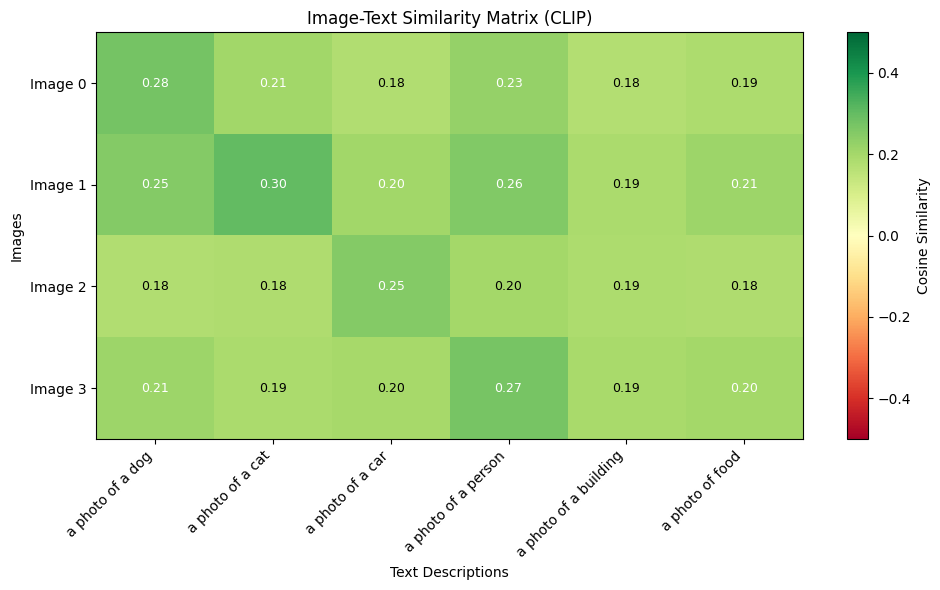

In [9]:
# Convert to numpy for plotting
sim_matrix = similarity.cpu().numpy()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(sim_matrix, cmap='RdYlGn', aspect='auto', vmin=-0.5, vmax=0.5)

# Add labels
ax.set_xticks(range(len(texts)))
ax.set_xticklabels(texts, rotation=45, ha='right')
ax.set_yticks(range(len(images)))
ax.set_yticklabels([f'Image {i}' for i in range(len(images))])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity')

# Add values in cells
for i in range(len(images)):
    for j in range(len(texts)):
        text_color = 'white' if abs(sim_matrix[i, j]) > 0.2 else 'black'
        ax.text(j, i, f'{sim_matrix[i, j]:.2f}', 
                ha='center', va='center', color=text_color, fontsize=9)

ax.set_title('Image-Text Similarity Matrix (CLIP)')
ax.set_xlabel('Text Descriptions')
ax.set_ylabel('Images')

plt.tight_layout()
plt.show()

## 5. Example: Image Search by Text

Given a text query, find the best matching image.

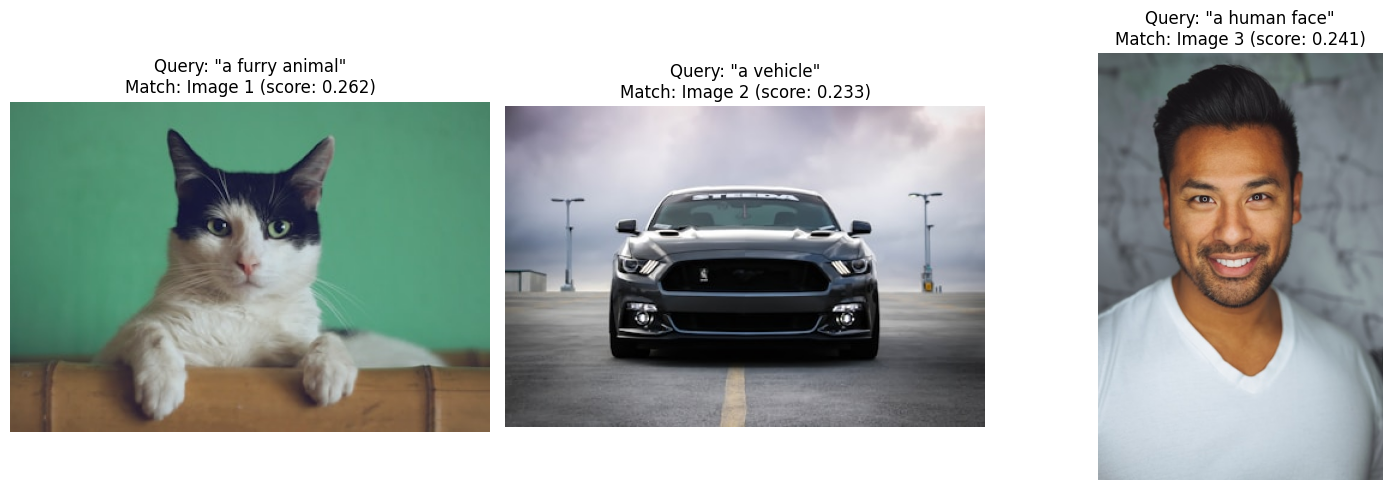

In [10]:
def search_images_by_text(matcher, images, query_texts):
    """Search for best matching images given text queries."""
    # Add new query texts
    matcher.add_texts(query_texts)
    
    # Compute similarity
    similarity = matcher.compute_similarity()
    
    # Display results
    n_queries = len(query_texts)
    fig, axes = plt.subplots(1, n_queries, figsize=(5*n_queries, 5))
    if n_queries == 1:
        axes = [axes]
    
    for i, query in enumerate(query_texts):
        # Get best matching image
        scores = similarity[:, i]
        best_idx = scores.argmax().item()
        best_score = scores[best_idx].item()
        
        axes[i].imshow(images[best_idx])
        axes[i].set_title(f'Query: "{query}"\nMatch: Image {best_idx} (score: {best_score:.3f})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Search with different queries
queries = ["a furry animal", "a vehicle", "a human face"]
search_images_by_text(matcher, images, queries)

## 6. Example: Find Best Text for Image

Given an image, find the best matching text description.

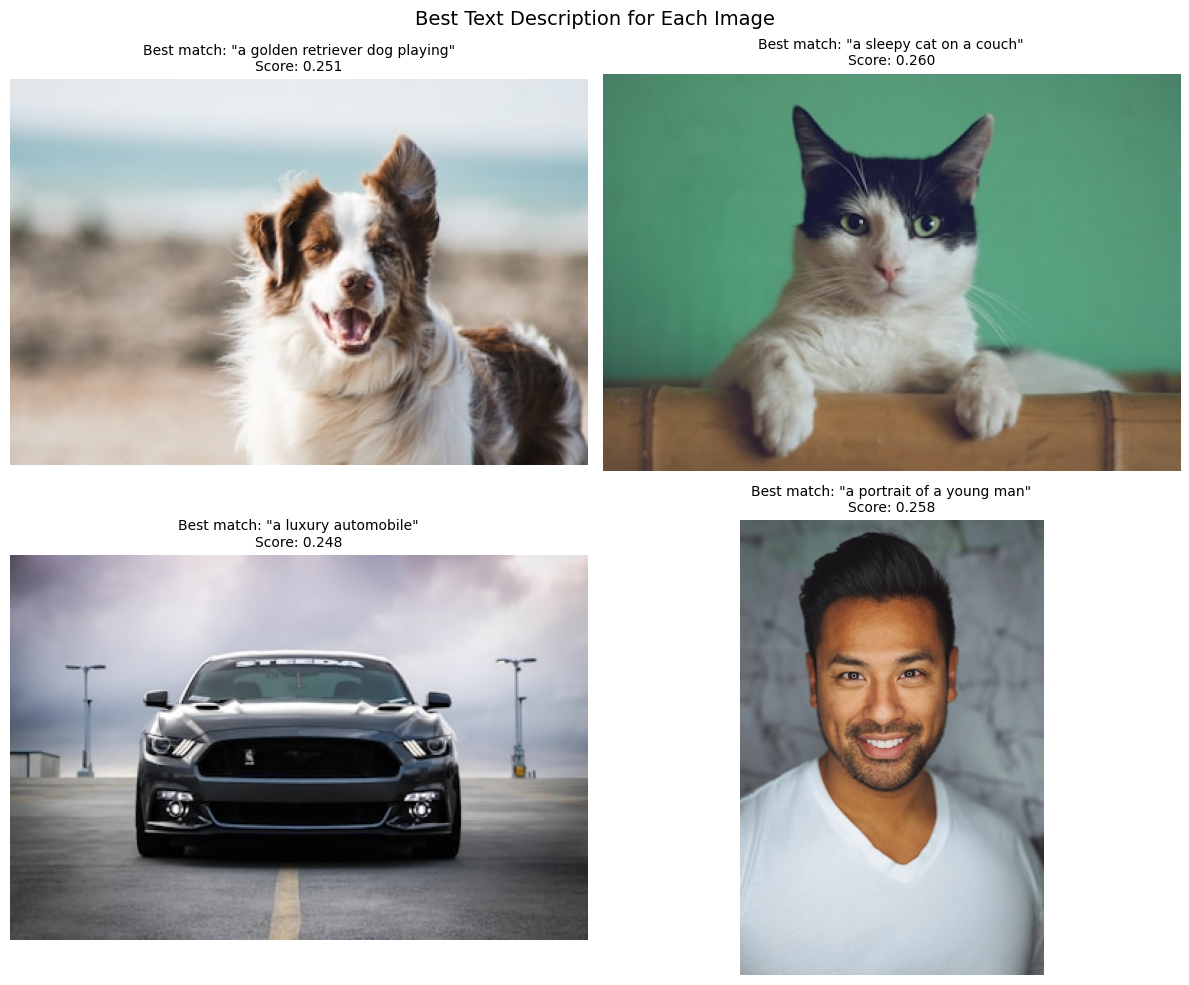

In [11]:
# Reset and add candidate descriptions
matcher.clear()

candidate_texts = [
    "a golden retriever dog playing",
    "a sleepy cat on a couch",
    "a sports car on the road",
    "a portrait of a young man",
    "a landscape with mountains",
    "a bowl of fresh fruit",
    "a cute puppy",
    "a luxury automobile",
]

matcher.add_texts(candidate_texts)
matcher.add_images(images)

# For each image, find best matching text
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(min(4, len(images))):
    best_text, score = matcher.get_best_text_match(image_idx=i)
    
    axes[i].imshow(images[i])
    axes[i].set_title(f'Best match: "{best_text}"\nScore: {score:.3f}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Best Text Description for Each Image', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Working with Torch Tensors

You can also pass images as PyTorch tensors.

In [12]:
import torchvision.transforms as T

# Convert PIL images to tensor
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),  # Converts to [0, 1] range
])

# Stack into batch tensor
image_tensors = torch.stack([transform(img) for img in images])
print(f'Image tensor shape: {image_tensors.shape}')

# Use tensor with matcher
matcher.clear()
matcher.add_texts(["animal", "vehicle", "person"])
matcher.add_images(image_tensors)  # Pass tensor directly

similarity = matcher.compute_similarity()
print(f'\nSimilarity matrix:')
print(similarity.cpu().numpy().round(3))

Image tensor shape: torch.Size([4, 3, 224, 224])

Similarity matrix:
[[0.227 0.191 0.21 ]
 [0.244 0.212 0.239]
 [0.218 0.244 0.198]
 [0.208 0.2   0.219]]


## 8. Ranking All Texts for an Image

In [13]:
# Add more diverse texts
matcher.clear()

all_texts = [
    "a dog", "a cat", "a car", "a person",
    "an animal", "a pet", "a vehicle", "a mammal",
    "something cute", "something fast", "a living creature",
]

matcher.add_texts(all_texts)
matcher.add_images([images[0]])  # Just the first image (dog)

similarity = matcher.compute_similarity()[0]  # Get scores for first image

# Rank texts by similarity
rankings = sorted(zip(all_texts, similarity.cpu().numpy()), key=lambda x: -x[1])

print("Text rankings for the first image (dog):")
print("-" * 40)
for rank, (text, score) in enumerate(rankings, 1):
    print(f"{rank:2d}. {text:25s} {score:.4f}")

Text rankings for the first image (dog):
----------------------------------------
 1. a dog                     0.2523
 2. a pet                     0.2408
 3. an animal                 0.2347
 4. a mammal                  0.2271
 5. a living creature         0.2266
 6. something cute            0.2103
 7. a person                  0.2058
 8. a cat                     0.1945
 9. a vehicle                 0.1868
10. something fast            0.1844
11. a car                     0.1783


## Summary

The `ImageTextMatcher` class provides a simple interface for CLIP-based image-text matching:

| Method | Description |
|--------|-------------|
| `add_texts(texts)` | Add text descriptions |
| `add_images(images)` | Add images (PIL, numpy, or tensor) |
| `compute_similarity()` | Get (images, texts) similarity matrix |
| `get_best_text_match(idx)` | Find best text for an image |
| `get_best_image_match(idx)` | Find best image for a text |
| `clear()` | Reset all stored data |

### Use Cases
- **Image search**: Find images matching a text query
- **Image captioning**: Generate candidate captions and rank them
- **Zero-shot classification**: Classify images using text labels
- **Content moderation**: Check if images match certain descriptions

## 9. Softmax Probabilities for Ranking

Instead of raw cosine similarities, use softmax to get probability distributions over text options. This is more robust for verification tasks.

In [14]:
# Compare raw similarity vs softmax probabilities
matcher.clear()

texts = ["a dog", "a cat", "a car", "a person"]
matcher.add_texts(texts)
matcher.add_images(images)

# Raw cosine similarity
raw_similarity = matcher.compute_similarity()

# Softmax probabilities (sum to 1 for each image)
softmax_probs = matcher.compute_softmax_scores(temperature=100.0)

print("Raw Cosine Similarity:")
print(raw_similarity.cpu().numpy().round(3))
print(f"\nRow sums: {raw_similarity.sum(dim=1).cpu().numpy().round(3)}")

print("\n" + "="*50)
print("\nSoftmax Probabilities (temperature=100):")
print(softmax_probs.cpu().numpy().round(3))
print(f"\nRow sums: {softmax_probs.sum(dim=1).cpu().numpy().round(3)}  (should be 1.0)")

Raw Cosine Similarity:
[[0.252 0.194 0.178 0.206]
 [0.23  0.282 0.197 0.233]
 [0.176 0.184 0.249 0.185]
 [0.2   0.189 0.193 0.235]]

Row sums: [0.831 0.942 0.795 0.817]


Softmax Probabilities (temperature=100):
[[0.987 0.003 0.001 0.009]
 [0.005 0.987 0.    0.007]
 [0.001 0.001 0.996 0.002]
 [0.03  0.01  0.014 0.946]]

Row sums: [1. 1. 1. 1.]  (should be 1.0)


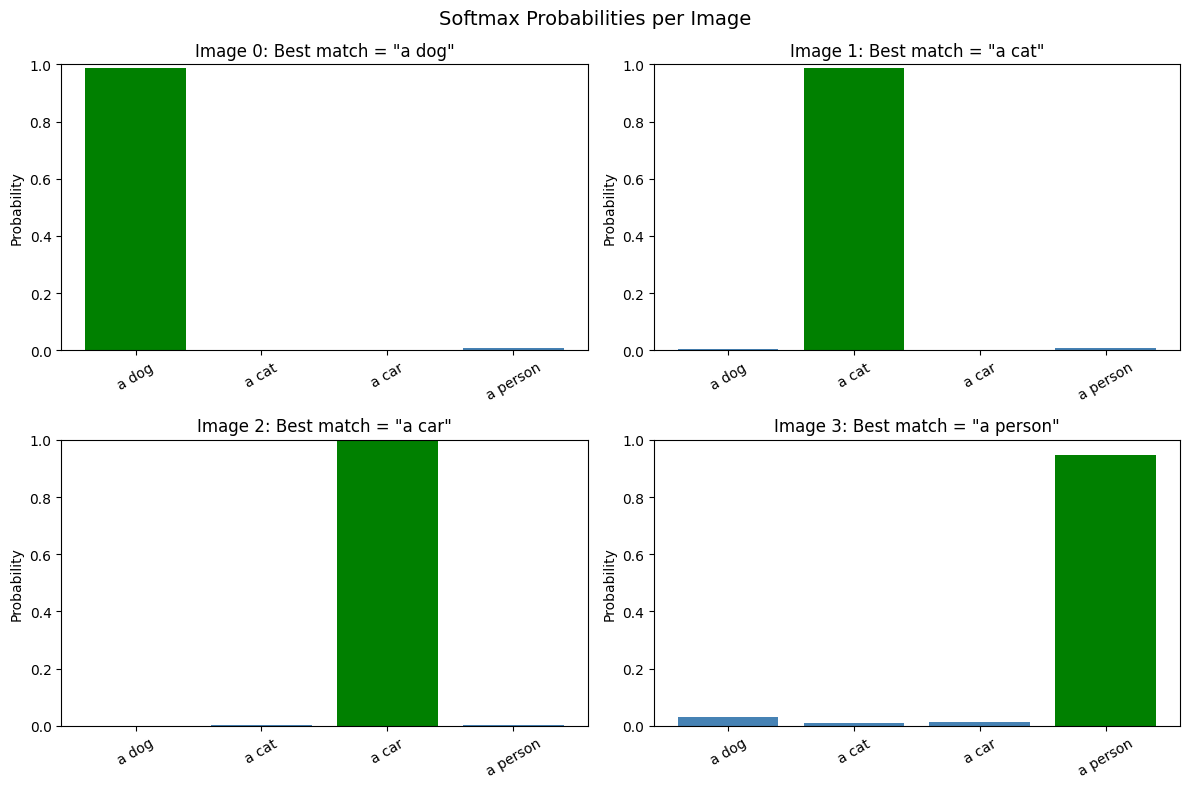

In [15]:
# Visualize softmax probabilities as bar charts
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

probs_np = softmax_probs.cpu().numpy()
colors = ['green' if i == probs_np[j].argmax() else 'steelblue' 
          for j in range(4) for i in range(4)]

for i in range(4):
    bar_colors = ['green' if j == probs_np[i].argmax() else 'steelblue' for j in range(4)]
    axes[i].bar(texts, probs_np[i], color=bar_colors)
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'Image {i}: Best match = "{texts[probs_np[i].argmax()]}"')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=30)

plt.suptitle('Softmax Probabilities per Image', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Detection Verification Pipeline

Use CLIP to verify/filter detections from an object detector. Instead of using arbitrary thresholds, rank the positive description against negative alternatives.

In [16]:
# Simulate detection verification scenario
# Imagine we have 4 "detections" (our images) and want to verify which are dogs

matcher.clear()

# Positive description first, then negatives
descriptions = [
    "a dog",           # Index 0: positive (what we're looking for)
    "a cat",           # Index 1: negative
    "a vehicle",       # Index 2: negative  
    "a person",        # Index 3: negative
    "background noise" # Index 4: negative
]

matcher.add_texts(descriptions)
matcher.add_images(images)

# Verify which detections match "a dog" (index 0)
verified = matcher.verify_detections(positive_idx=0, min_score=0.15)

print("Detection Verification Results:")
print("=" * 50)
for i, is_verified in enumerate(verified):
    status = "✓ VERIFIED" if is_verified else "✗ REJECTED"
    similarity = matcher.compute_similarity()[i, 0].item()
    print(f"Image {i}: {status} (score: {similarity:.3f})")

Detection Verification Results:
Image 0: ✓ VERIFIED (score: 0.252)
Image 1: ✗ REJECTED (score: 0.230)
Image 2: ✗ REJECTED (score: 0.176)
Image 3: ✗ REJECTED (score: 0.200)


## Summary

The `ImageTextMatcher` class provides a simple interface for CLIP-based image-text matching:

| Method | Description |
|--------|-------------|
| `add_texts(texts)` | Add text descriptions |
| `add_images(images)` | Add images (PIL, numpy, or tensor) |
| `compute_similarity()` | Get (images, texts) cosine similarity matrix |
| `compute_softmax_scores(temp)` | Get probability distribution over texts |
| `verify_detections(pos_idx)` | Boolean mask for detection filtering |
| `get_best_text_match(idx)` | Find best text for an image |
| `get_best_image_match(idx)` | Find best image for a text |
| `clear()` | Reset all stored data |

### Use Cases
- **Image search**: Find images matching a text query
- **Zero-shot classification**: Classify images using text labels
- **Detection verification**: Filter detector outputs using text descriptions
- **Content moderation**: Check if images match certain descriptions

### Key Takeaway: Ranking vs Thresholding
For verification tasks, prefer **ranking** (positive vs negatives) over **absolute thresholds**:
```python
# Better: Does "target" beat alternatives?
matcher.add_texts(["target description", "negative 1", "negative 2"])
verified = matcher.verify_detections(positive_idx=0)

# Avoid: Arbitrary threshold
verified = similarity > 0.25  # Threshold varies by query!
```